In [1]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import color_gif_from_array, make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis
import argparse
from src.NICE_SLAM import NICE_SLAM
from src import config
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
parser = argparse.ArgumentParser(
description="Arguments for running the NICE-SLAM/iMAP*."
)
parser.add_argument("config", type=str, help="Path to config file.")
parser.add_argument(
    "--input_folder",
    type=str,
    help="input folder, this have higher priority, can overwrite the one in config file",
)
parser.add_argument(
    "--output",
    type=str,
    help="output folder, this have higher priority, can overwrite the one in config file",
)
nice_parser = parser.add_mutually_exclusive_group(required=False)
nice_parser.add_argument("--nice", dest="nice", action="store_true")
nice_parser.add_argument("--imap", dest="nice", action="store_false")
parser.set_defaults(nice=True)
args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/Own/room0.yaml'])
cfg = config.load_config(  # J:changed it to use our config file including semantics
        args.config, "configs/nice_slam_sem.yaml" if args.nice else "configs/imap.yaml"
    )
slam = NICE_SLAM(cfg, args)

INFO: The output folder is output/Own/room0
INFO: The GT, generated and residual depth/color images can be found under output/Own/room0/mapping_vis/
INFO: The mesh can be found under output/Own/room0/mesh/
INFO: The checkpoint can be found under output/Own/room0/ckpt/


In [3]:
slam.set_log_dict('/home/rozenberszki/project/wsnsl/output/Own/room0_small/ckpts/00059.tar', map_location='cuda')

In [4]:
depth, uncertainty, color, semantic = slam.renderer.render_img( #Done add semantics
                    slam.shared_c,
                    slam.shared_decoders,
                    slam.frame_reader.poses[20].to('cuda'),
                    'cuda',
                    stage='visualize',
                    gt_depth=None)

/home/rozenberszki/anaconda3/envs/wsnsl/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
from src.utils import vis
visualizerForIds = vis.visualizerForIds()

In [6]:
depth_np = depth.detach().cpu().numpy()
color_np = color.detach().cpu().numpy()
semantic_np = semantic.detach().cpu().numpy()

In [7]:
max_depth = np.max(depth_np)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


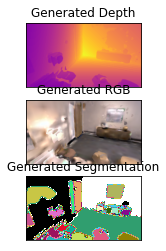

In [8]:
fig, axs = plt.subplots(3)

axs[0].imshow(depth_np, cmap="plasma",
                vmin=0, vmax=max_depth)
axs[0].set_title('Generated Depth')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(color_np, cmap="plasma")
axs[1].set_title('Generated RGB')
axs[1].set_xticks([])
axs[1].set_yticks([])
#------------------added------------------
semantic_argmax = np.argmax(semantic_np, axis=2)
axs[2], im = visualizerForIds.visualize(semantic_argmax, ax=axs[2], title='Generated Segmentation')
axs[2].set_xticks([])
axs[2].set_yticks([])
plt.show()


In [9]:
from tqdm import tqdm

In [10]:
poses = slam.frame_reader.poses[:60]
poses

[tensor([[-3.2057e-01, -4.4806e-01,  8.3455e-01,  3.4530e+00],
         [ 9.4722e-01, -1.5164e-01,  2.8244e-01,  4.5461e-01],
         [ 1.0790e-16,  8.8105e-01,  4.7302e-01,  5.9363e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]),
 tensor([[-3.1393e-01, -4.5307e-01,  8.3437e-01,  3.4572e+00],
         [ 9.4945e-01, -1.4981e-01,  2.7588e-01,  4.6971e-01],
         [ 1.0762e-16,  8.7880e-01,  4.7719e-01,  5.9427e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]),
 tensor([[-3.0848e-01, -4.5677e-01,  8.3439e-01,  3.4614e+00],
         [ 9.5123e-01, -1.4812e-01,  2.7058e-01,  4.8419e-01],
         [ 1.0742e-16,  8.7717e-01,  4.8018e-01,  5.9430e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]),
 tensor([[-3.0417e-01, -4.5922e-01,  8.3463e-01,  3.4657e+00],
         [ 9.5262e-01, -1.4663e-01,  2.6649e-01,  4.9806e-01],
         [ 1.0730e-16,  8.7614e-01,  4.8206e-01,  5.9373e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, 

In [11]:
depths, colors, semantics = [], [], []
for c2w in tqdm(poses[::20]):
    depth, _ , color, semantic = slam.renderer.render_img(
        slam.shared_c,
        slam.shared_decoders,
        c2w.to('cuda'),
        'cuda',
        stage='visualize',
        gt_depth=None
    )
    depth_np = depth.detach().cpu().numpy()
    color_np = color.detach().cpu().numpy()
    semantic_np = semantic.detach().cpu().numpy()
    semantic_argmax = np.argmax(semantic_np, axis=2)
    depths.append(depth_np)
    colors.append(color_np)
    semantics.append(semantic_argmax)

100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


In [12]:
depths = np.stack(depths)
depths /= np.max(depths)

In [13]:
color_gif_from_array(colors, 'test_color.gif')
color_gif_from_array(depths, 'test_depth.gif')
make_gif_from_array(semantics, 'test_semantic.gif')